# Why Dask
- Lazy processing
- Large file (not fitting in the memory)
- Parallelization (use all available computational resources)

# Imaport and init Dask

First follow the instruction and install Dast extension for Jupyter lab: https://github.com/dask/dask-labextension

If you got an error during enabling extension, this issue might help you: https://stackoverflow.com/questions/63516924/typeerror-init-got-an-unexpected-keyword-argument-requote

### Jupyter lab extension

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:62942")
client

<Client: 'tcp://127.0.0.1:62942' processes=4 threads=8, memory=16.98 GB>

In [2]:
# Dask imports
import dask.array as da

# non-Dask imports
import numpy as np

# Using Dask arrays instead of Numpy

Dask arrays coordinate many Numpy arrays, arranged into chunks within a grid. They support a large subset of the Numpy API.

In [3]:
x = np.random.random((100000,10000,100))
x

MemoryError: 

In [31]:
# Dask Version
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [32]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

In [33]:
k = z.compute() #Lazy computation

In [34]:
type(k)

numpy.ndarray

If you have the available RAM for your dataset then you can persist data in memory (it is faster and does not need to run the pipeline from the begining).



In [35]:
# Don't do this
# z.persist()

# Do this, replace lazy variable
z = z.persist()
z[0].compute()

0.9990060834343981

In [36]:
z.mean().compute()

1.0001942212574693

# Dask Bag (map, filter, reduce)
https://docs.dask.org/en/latest/bag-api.html

Dask Bag implements operations like map, filter, reductions and aggregations on collections of Python objects

In [3]:
import dask
import json
import os

# os.makedirs('data', exist_ok=True) # Create data/ directory

b = dask.datasets.make_people() # Make records of people; it is a Dask Bag; this is lazy and won't generate unless you call an excutive like compute() or take() or ...
b
# type(b)

dask.bag<mimesis..., npartitions=10>

In [4]:
txt = b.map(json.dumps) #map function applies a function on all members of a bag and it do it in parallel fashion
txt.take(2)
# type(txt)

('{"age": 62, "name": ["Carley", "Knapp"], "occupation": "Hypnotherapist", "telephone": "207.980.1259", "address": {"address": "48 Brice Trace", "city": "Saratoga"}, "credit-card": {"number": "3417 277300 37070", "expiration-date": "03/20"}}',
 '{"age": 56, "name": ["Eddy", "Chambers"], "occupation": "Matron", "telephone": "1-267-417-7509", "address": {"address": "379 Saint Charles Spur", "city": "Elizabeth City"}, "credit-card": {"number": "5364 8722 4863 4298", "expiration-date": "08/21"}}')

In [5]:
b.map(json.dumps).to_textfiles('data/*.json')   # You can make a parallel pipline by unsing .

["C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/0.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/1.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/2.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/3.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/4.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/5.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/6.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/D

### Work with jsons, in two different fashions

In [3]:
%%time

# standard way
import json
from os import walk

data =[]
for (dirpath, dirnames, filenames) in walk('data'):
    for file in filenames:
        filepath = 'data/' + file
        with open(filepath) as json_file:
#             print (filepath)
            for line in json_file:
                 data.append(json.loads(line))
len(data)

Wall time: 229 ms


10000

In [4]:
%%time

#dask way
import dask.bag as db
import json

b = db.read_text('data/*.json').map(json.loads)
b.count().compute()

Wall time: 405 ms


10000

In [5]:
b

dask.bag<loads-d..., npartitions=10>

#### Filters

In [6]:
%%time

# standard way
p30 =[]
for per in data:
    if per['age'] > 30:
        p30.append(per)
        
len(p30)

Wall time: 3 ms


7122

In [7]:
%%time

# Dask way
b.filter(lambda item: item['age'] > 30).take(2)

Wall time: 26.5 ms


({'age': 62,
  'name': ['Carley', 'Knapp'],
  'occupation': 'Hypnotherapist',
  'telephone': '207.980.1259',
  'address': {'address': '48 Brice Trace', 'city': 'Saratoga'},
  'credit-card': {'number': '3417 277300 37070', 'expiration-date': '03/20'}},
 {'age': 56,
  'name': ['Eddy', 'Chambers'],
  'occupation': 'Matron',
  'telephone': '1-267-417-7509',
  'address': {'address': '379 Saint Charles Spur', 'city': 'Elizabeth City'},
  'credit-card': {'number': '5364 8722 4863 4298',
   'expiration-date': '08/21'}})

In [8]:
# powerful pipelining of bags
result = (b.filter(lambda record: record['age'] > 30).map(lambda record: record['occupation']).frequencies(sort=True).topk(10, key=1))
result.compute()

[('Baptist Minister', 14),
 ('Tax Manager', 14),
 ('Advertising Contractor', 14),
 ('Lift Engineer', 14),
 ('Plastics Engineer', 13),
 ('Taxi Controller', 13),
 ('Clergyman', 13),
 ('Stockman', 13),
 ('Metal Polisher', 13),
 ('Nursery Nurse', 13)]

#### write to disk for future

In [9]:
(b.filter(lambda record: record['age'] > 30)
.map(json.dumps) # Convert Python objects to text
.to_textfiles('data/processed.*.json')) # It will generate a file for each partition and * will be replaced by a sequence 0, 1, 2, ... . You can introduce a name function for file names, using name_function argument

# other formats like avro are available, read https://docs.dask.org/en/latest/bag-api.html#turn-bags-into-other-things

["C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/processed.0.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/processed.1.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/processed.2.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/processed.3.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/processed.4.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/processed.5.json",
 "C:/Amin's Personal Data/University/Teaching/Winter 2021/Special topics in Data Science/Data-Science-Course/7-Dask/data/processed.6.json",
 "C:/Amin's Personal

In [10]:
b.take(2)

({'age': 62,
  'name': ['Carley', 'Knapp'],
  'occupation': 'Hypnotherapist',
  'telephone': '207.980.1259',
  'address': {'address': '48 Brice Trace', 'city': 'Saratoga'},
  'credit-card': {'number': '3417 277300 37070', 'expiration-date': '03/20'}},
 {'age': 56,
  'name': ['Eddy', 'Chambers'],
  'occupation': 'Matron',
  'telephone': '1-267-417-7509',
  'address': {'address': '379 Saint Charles Spur', 'city': 'Elizabeth City'},
  'credit-card': {'number': '5364 8722 4863 4298',
   'expiration-date': '08/21'}})

In [30]:
# Convert Dask Bag to Dask Dataframe
dd = b.to_dataframe()
dd.head()

age                name            occupation     telephone  \
0   27   [Kimbery, Hansen]               Breeder  901.926.8360   
1   29     [Chong, Dennis]     Highway Inspector  602.386.4812   
2   21    [Yuki, Humphrey]          Spring Maker  553-125-7835   
3   60   [Zachariah, Love]            Tour Guide  339.046.7719   
4   19  [Alfredo, Knowles]  Television Presenter  346-837-2029   

                                             address  \
0   {'address': '356 Fell Line', 'city': 'Kingston'}   
1  {'address': '1234 Borica Hill', 'city': 'McKee...   
2  {'address': '840 Battery Safford Mews', 'city'...   
3  {'address': '433 Virgil Pike', 'city': 'Rio Ra...   
4  {'address': '1278 Cedro Glen', 'city': 'Hollis...   

                                         credit-card  
0  {'number': '2527 4590 4760 4234', 'expiration-...  
1  {'number': '4661 9183 5132 2396', 'expiration-...  
2  {'number': '5558 3077 2036 1934', 'expiration-...  
3  {'number': '4675 7394 8789 4528', 'expiration-...  
4  {'number': '3458 895988 83544', 'expiration-da...

In [31]:
b.take(1)

({'age': 27,
  'name': ['Kimbery', 'Hansen'],
  'occupation': 'Breeder',
  'telephone': '901.926.8360',
  'address': {'address': '356 Fell Line', 'city': 'Kingston'},
  'credit-card': {'number': '2527 4590 4760 4234',
   'expiration-date': '11/24'}},)

In [11]:
# flatten some of the composed values in JSON
def flatten(record):
    return {
        'age': record['age'],
        'name': ' '.join(record['name']),
        'occupation': record['occupation'],
        'telephone': record['telephone'],
        'credit-card-number': record['credit-card']['number'],
        'credit-card-expiration': record['credit-card']['expiration-date'],
        'street-address': record['address']['address'],
        'city': record['address']['city']
    }

In [12]:
dd = b.map(flatten).to_dataframe()
dd.head()

age             name          occupation       telephone  \
0   62     Carley Knapp      Hypnotherapist    207.980.1259   
1   56    Eddy Chambers              Matron  1-267-417-7509   
2   54  Glinda Hamilton  Restaurant Manager  (355) 727-0377   
3   22      Dania Brock     Service Manager    213.922.4406   
4   33      Keneth Dunn        Tree Surgeon    188.894.3073   

    credit-card-number credit-card-expiration          street-address  \
0    3417 277300 37070                  03/20          48 Brice Trace   
1  5364 8722 4863 4298                  08/21  379 Saint Charles Spur   
2  2556 9811 3191 2565                  03/17  72 Bonview High Street   
3  4470 8399 3921 6895                  02/16        1005 Ash Terrace   
4  5425 3740 3458 4248                  07/20   590 Harrington Garden   

             city  
0        Saratoga  
1  Elizabeth City  
2          Warren  
3         Chester  
4   New Braunfels

# Using Dask Dataframe instead of Pandas Dataframe

API documentation: https://docs.dask.org/en/latest/dataframe.html

Very similar to Panadas, so less efforts to learn it.

Dask DataFrames coordinate many Pandas DataFrames/Series arranged along the index. A Dask DataFrame is partitioned row-wise, grouping rows by index value for efficiency. These Pandas objects may live on disk or on other machines.

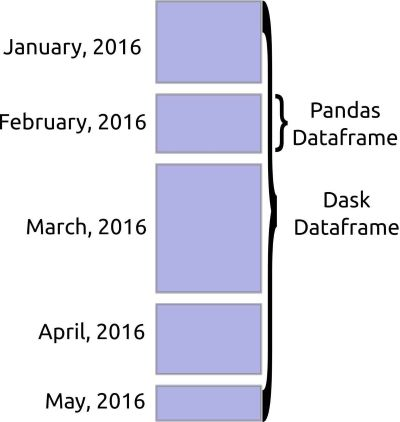

### Dask dataframe use cases

+ Manipulating large datasets, even when those datasets don’t fit in memory
+ Accelerating long computations by using many cores
+ Distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations

### Do not use it for the followings:

+ If your dataset fits comfortably into RAM on your laptop, then you may be better off just using Pandas. There may be simpler ways to improve performance than through parallelism
+ If your dataset doesn’t fit neatly into the Pandas tabular model, then you might find more use in dask.bag or dask.array
+ If you need functions that are not implemented in Dask DataFrame, then you might want to look at dask.delayed which offers more flexibility
+ If you need a proper database with all that databases offer you might prefer something like Postgres

In [14]:
import dask
df = dask.datasets.timeseries()
df
# when you are dealing with big data partition key (in Dask known as index) is a very important factor in performance

Dask DataFrame Structure:
                   id    name        x        y
npartitions=30                                 
2000-01-01      int32  object  float64  float64
2000-01-02        ...     ...      ...      ...
...               ...     ...      ...      ...
2000-01-30        ...     ...      ...      ...
2000-01-31        ...     ...      ...      ...
Dask Name: make-timeseries, 30 tasks

In [15]:
df.loc['2000-01-01'].count().compute()

id      86400
name    86400
x       86400
y       86400
dtype: int64

In [16]:
df.head()

id     name         x         y
timestamp                                             
2000-01-01 00:00:00   994   Hannah  0.417467 -0.963468
2000-01-01 00:00:01  1036   Ingrid  0.520951  0.320360
2000-01-01 00:00:02  1032  Michael  0.894931  0.703961
2000-01-01 00:00:03   936   Hannah -0.897849 -0.789327
2000-01-01 00:00:04   974   Ingrid -0.104563 -0.887198

In [19]:
df.get_partition(0).compute()

id     name         x         y
timestamp                                             
2000-01-01 00:00:00   994   Hannah  0.417467 -0.963468
2000-01-01 00:00:01  1036   Ingrid  0.520951  0.320360
2000-01-01 00:00:02  1032  Michael  0.894931  0.703961
2000-01-01 00:00:03   936   Hannah -0.897849 -0.789327
2000-01-01 00:00:04   974   Ingrid -0.104563 -0.887198
...                   ...      ...       ...       ...
2000-01-01 23:59:55  1048   Yvonne -0.117395  0.382246
2000-01-01 23:59:56   996   Ingrid -0.849430 -0.229336
2000-01-01 23:59:57  1013  Charlie  0.511816 -0.274844
2000-01-01 23:59:58  1064   Yvonne  0.560298 -0.764367
2000-01-01 23:59:59  1007   Ursula  0.499728 -0.775391

[86400 rows x 4 columns]

In [20]:
import os
import datetime

if not os.path.exists('data/timeseries'):
    os.mkdir('data/timeseries')

def name(i):
    return str(datetime.date(2000, 1, 1) + i * datetime.timedelta(days=1))
    
df.to_csv('data/timeseries/*.csv', name_function=name);

In [21]:
import pandas as pd
df = pd.read_csv('data/timeseries/2000-01-01.csv')
# type(df['timestamp'][0])
df.head()

timestamp    id     name         x         y
0  2000-01-01 00:00:00   994   Hannah  0.417467 -0.963468
1  2000-01-01 00:00:01  1036   Ingrid  0.520951  0.320360
2  2000-01-01 00:00:02  1032  Michael  0.894931  0.703961
3  2000-01-01 00:00:03   936   Hannah -0.897849 -0.789327
4  2000-01-01 00:00:04   974   Ingrid -0.104563 -0.887198

In [22]:
from dask.dataframe import DataFrame
df = dask.dataframe.read_csv("data/timeseries/2000-01-01.csv", parse_dates=['timestamp'])
df

Dask DataFrame Structure:
                    timestamp     id    name        x        y
npartitions=1                                                 
               datetime64[ns]  int64  object  float64  float64
                          ...    ...     ...      ...      ...
Dask Name: from-delayed, 3 tasks

In [23]:
df.head()

timestamp    id     name         x         y
0 2000-01-01 00:00:00   994   Hannah  0.417467 -0.963468
1 2000-01-01 00:00:01  1036   Ingrid  0.520951  0.320360
2 2000-01-01 00:00:02  1032  Michael  0.894931  0.703961
3 2000-01-01 00:00:03   936   Hannah -0.897849 -0.789327
4 2000-01-01 00:00:04   974   Ingrid -0.104563 -0.887198

In [43]:
# read all files in a folder with a pattern and put them in partitions
df = dask.dataframe.read_csv("data/timeseries/2000-*-*.csv", parse_dates=['timestamp'])
df

Dask DataFrame Structure:
                     timestamp     id    name        x        y
npartitions=30                                                 
                datetime64[ns]  int64  object  float64  float64
                           ...    ...     ...      ...      ...
...                        ...    ...     ...      ...      ...
                           ...    ...     ...      ...      ...
                           ...    ...     ...      ...      ...
Dask Name: from-delayed, 90 tasks

In [44]:
df = df.set_index('timestamp')
df

Dask DataFrame Structure:
                        id    name        x        y
npartitions=30                                      
2000-01-01 00:00:00  int64  object  float64  float64
2000-01-02 00:00:00    ...     ...      ...      ...
...                    ...     ...      ...      ...
2000-01-30 00:00:00    ...     ...      ...      ...
2000-01-30 23:59:59    ...     ...      ...      ...
Dask Name: sort_index, 150 tasks

In [29]:
# The index enables me to answer queries much faster when it falls within a partition
# Dask will be able to narrow down search instead of looking all paritions for matching records

# df.loc['2000-01-01 03'].compute()
df.loc['2000-01-01 01'].count().compute()

id      3600
name    3600
x       3600
y       3600
dtype: int64

In [30]:
# each Dask dataframe is set of Pandas dataframe, called partition
# to apply regular Pandas function on each partition of a Dask dataframe use map_partitions(func)
df.map_partitions(len).compute()

0     86400
1     86400
2     86400
3     86400
4     86400
5     86400
6     86400
7     86400
8     86400
9     86400
10    86400
11    86400
12    86400
13    86400
14    86400
15    86400
16    86400
17    86400
18    86400
19    86400
20    86400
21    86400
22    86400
23    86400
24    86400
25    86400
26    86400
27    86400
28    86400
29    86400
dtype: int64

In [31]:
%time df.groupby('name').x.mean().compute()

Wall time: 2.9 s


name
Alice       0.000571
Bob        -0.000093
Charlie     0.000371
Dan        -0.001295
Edith      -0.001225
Frank      -0.002157
George     -0.000759
Hannah     -0.000015
Ingrid      0.000415
Jerry      -0.001042
Kevin       0.000242
Laura      -0.001812
Michael    -0.001958
Norbert     0.000615
Oliver     -0.000740
Patricia   -0.001438
Quinn      -0.002377
Ray        -0.000673
Sarah       0.000797
Tim        -0.000472
Ursula     -0.001604
Victor      0.000771
Wendy      -0.000675
Xavier      0.000531
Yvonne     -0.001812
Zelda      -0.001476
Name: x, dtype: float64

In [32]:
%time df.groupby('name').agg({'x': ['mean', 'std'], 'y': ['mean', 'count']}).compute().head()

Wall time: 2.77 s


x                   y        
             mean       std      mean   count
name                                         
Alice    0.000571  0.578833 -0.001023   99927
Bob     -0.000093  0.576678  0.000043  100170
Charlie  0.000371  0.576649 -0.000189   98886
Dan     -0.001295  0.577040  0.000295   99912
Edith   -0.001225  0.577285 -0.002170   99856

### Visualize computation graph
Before executing your computation you might consider visualizing the underlying task graph. By looking at the inter-connectedness of tasks you can learn more about potential bottlenecks where parallelism may not be possible, or areas where many tasks depend on each other, which may cause a great deal of communication.

The .visualize method and dask.visualize function work exactly like the .compute method and dask.compute function

In [51]:
# Computational graph of a single output aggregation (for a small number of groups, like 1000)
# df.groupby('name').x.sum().visualize(node_attr={'penwidth': '6'})
df.groupby('name').x.mean().visualize(node_attr={'penwidth': '6'}) #notice that mean is translated to sum and count
# df.groupby('name').x.mean().compute()

In [47]:
# you can control the direction for drawing graph
df.groupby('name').x.mean().visualize(rankdir="LR",node_attr={'penwidth': '6'})

In [53]:
# If the output is large, then you can split the output too. Computational graph of an aggregation to four outputs (for a larger number of groups, like 1000000)
# df.groupby('name').x.sum(split_out=4).visualize(rankdir="LR",node_attr={'penwidth': '6'})
# df.groupby('name').x.mean(split_out=4).visualize(node_attr={'penwidth': '6'})
df.groupby('name').x.mean(split_out=4).compute()

name
Charlie     0.000371
Kevin       0.000242
Dan        -0.001295
Edith      -0.001225
George     -0.000759
Ray        -0.000673
Sarah       0.000797
Zelda      -0.001476
Alice       0.000571
Frank      -0.002157
Jerry      -0.001042
Norbert     0.000615
Oliver     -0.000740
Patricia   -0.001438
Tim        -0.000472
Ursula     -0.001604
Victor      0.000771
Xavier      0.000531
Bob        -0.000093
Hannah     -0.000015
Ingrid      0.000415
Laura      -0.001812
Michael    -0.001958
Quinn      -0.002377
Wendy      -0.000675
Yvonne     -0.001812
Name: x, dtype: float64

## Write to Parquet
https://parquet.apache.org/documentation/latest/

Parquet is a columnar file format in Hadoop ecosystem available to many languages and models. It's super efficient on top of HDFS.

Parquet has the following benefits:
+ It's a columnar storage (very helpful when working with a part of data; also provides better options for compression)
+ Keeps the index and partitions as is (CSV doesn't)

In [40]:
df.to_parquet('data/timeseries/2000-01.parquet', engine='pyarrow')

In [41]:
df_smaller = dask.dataframe.read_parquet('data/timeseries/2000-01.parquet', columns=['name','x']) # I just read some columns, not the whole data
df_smaller

Dask DataFrame Structure:
                       name        x
npartitions=30                      
2000-01-01 00:00:00  object  float64
2000-01-02 00:00:00     ...      ...
...                     ...      ...
2000-01-30 00:00:00     ...      ...
2000-01-30 23:59:59     ...      ...
Dask Name: read-parquet, 30 tasks

In [42]:
%time df_smaller.groupby('name').x.mean().compute()

Wall time: 553 ms


name
Alice       0.000571
Bob        -0.000093
Charlie     0.000371
Dan        -0.001295
Edith      -0.001225
Frank      -0.002157
George     -0.000759
Hannah     -0.000015
Ingrid      0.000415
Jerry      -0.001042
Kevin       0.000242
Laura      -0.001812
Michael    -0.001958
Norbert     0.000615
Oliver     -0.000740
Patricia   -0.001438
Quinn      -0.002377
Ray        -0.000673
Sarah       0.000797
Tim        -0.000472
Ursula     -0.001604
Victor      0.000771
Wendy      -0.000675
Xavier      0.000531
Yvonne     -0.001812
Zelda      -0.001476
Name: x, dtype: float64

# Using Dask to scale machine learning
It can be used as a tool for distributed training (if the model supports). 
Scikit-learn uses [joblib](https://joblib.readthedocs.io/en/latest/) for single-machine parallelism. 

This lets you train most estimators (anything that accepts an n_jobs parameter) using all the cores of your computer.

Scikit-Learn can use Dask for parallelism. This lets you train those estimators using all the cores of your cluster without significantly changing your code:
+ a large model when searching over many hyper-parameters (mid-size dataset)
+ an ensemble method with many individual estimators


In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [10]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, random_state=0) # 20 features, and 2 classes
X[:5]

array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
        -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
        -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
        -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159],
       [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
         2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
         0.54493439,  0.22532411,  0.60556322, -0.19210097, -0.06802699,
         0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.62323644],
       [ 0.94028404, -0.49214582,  0.67795602, -0.22775445,  1.40175261,
         1.23165333, -0.77746425,  0.01561602,  1.33171299,  1.08477266,
        -0.97805157, -0.05012039,  0.94838552, -0.17342825, -0.47767184,
         0.76089649,  1.00115812, -0.06946407,  1.35904607, -1.18958963],
       [-0.29951677,  0.75988955,  0.18280267, -1.55023271,  0.33821802,
         0.36324148, -2.10052547, -0.4380675 , -

In [6]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           iid=True,
                           cv=10)
#                           , n_jobs=-1)

In [7]:
%time grid_search.fit(X, y)

Wall time: 37.7 s


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [4]:
import numpy as np
from dask_ml.model_selection import GridSearchCV
from sklearn.svm import SVC

In [11]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           iid=True,
                           cv=10))

In [13]:
%time grid_search.fit(X, y)

Wall time: 17.1 s


GridSearchCV(cache_cv=True, cv=10, error_score='raise',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=0, shrinking=True,
                           tol=0.001, verbose=False),
             iid=True, n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]},
             refit=True, return_train_score=False, scheduler=None,
             scoring=None)

Most estimators in scikit-learn are designed to work on in-memory arrays. Training with larger datasets may require different algorithms.

All of the algorithms implemented in **Dask-ML** work well on larger than memory datasets, which you might store in a dask array or dataframe.
https://dask-ml.readthedocs.io/en/latest/

### clustering example


In [14]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [15]:
X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

In [16]:
%%time
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

Wall time: 11.8 s


KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=2,
       max_iter=300, n_clusters=3, n_jobs=1, oversampling_factor=10,
       precompute_distances='auto', random_state=None, tol=0.0001)

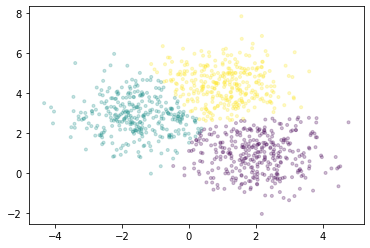

In [17]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

In [18]:
# equivalent task in sklearn without parallelization
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10000000, centers=3, n_features=2, random_state=0)
print(X.shape)

(10000000, 2)


In [19]:
%%time
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, max_iter=2)
km.fit(X)

Wall time: 42.3 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=2,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

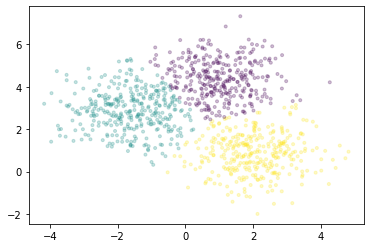

In [20]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

### XGBoost with Dask
Dask-ML can set up distributed XGBoost for you and hand off data from distributed dask.dataframes. This automates much of the hassle of preprocessing and setup while still letting XGBoost do what it does well.

In [21]:
from dask_ml.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)
X

dask.array<normal, shape=(100000, 20), dtype=float64, chunksize=(1000, 20), chunktype=numpy.ndarray>

In [22]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [23]:
X_train

dask.array<concatenate, shape=(85000, 20), dtype=float64, chunksize=(850, 20), chunktype=numpy.ndarray>

In [24]:
from dask_ml.xgboost import XGBRegressor # requirements: dask, dask_xgboost, xgboost

In [25]:
est = XGBRegressor()
est.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [26]:
prediction = est.predict(X_test)

In [27]:
prediction.compute()

array([0.09511396, 0.64261055, 0.61850464, ..., 0.4095412 , 0.1763261 ,
       0.39836287], dtype=float32)

In [28]:
from sklearn.metrics import roc_curve
import dask

# Note that the dask.compute() function returns in-memory results. 
# It converts Dask DataFrames to Pandas DataFrames, Dask arrays to NumPy arrays, and Dask bags to lists. 
# You should only call compute on results that will fit comfortably in memory.
y_test, y_hat = dask.compute(y_test, prediction) 
fpr, tpr, _ = roc_curve(y_test, prediction)

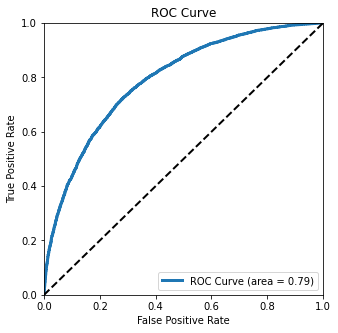

In [29]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

## Work with a cluster using Dask

After we setup a cluster, we initialize a Client by pointing it to the address of a **scheduler**.

The Client is the primary entry point for users of dask.distributed.

A cluster can be one of the followings:
+ Single machine 
+ SSH: Use SSH to set up Dask across an un-managed cluster.
+ High Performance Computers: How to run Dask on traditional HPC environments using tools like MPI, or job schedulers like SLURM, SGE, TORQUE, LSF, and so on.
+ Kubernetes: Deploy Dask with the popular Kubernetes resource manager using either Helm or a native deployment.
+ YARN / Hadoop: Deploy Dask on YARN clusters, such as are found in traditional Hadoop installations.
+ Python API (advanced): Create Scheduler and Worker objects from Python as part of a distributed Tornado TCP application.
+ Cloud for current recommendations on how to deploy Dask and Jupyter on common cloud providers like Amazon, Google, or Microsoft Azure.